<a href="https://colab.research.google.com/github/Max-Willians/projeto---meteora/blob/main/Notebook_Meteora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [2]:
# Importanto bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [3]:
# Dados para tabelas
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [4]:
# Leitura das tabelas com pandas
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [5]:
# Alocando tabelas no SQLite
engine = create_engine('sqlite:///:memory:')

In [6]:
# Adicionando tabelas no banco de dados
itens_pedidos.to_sql('itens_pedidos', engine, index = False)
pedidos.to_sql('pedidos', engine, index = False)
produtos.to_sql('produtos', engine, index = False)
vendedores.to_sql('vendedores', engine, index = False)

5

In [7]:
# Inspecionando tabelas
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [8]:
# Fazendo consulta
query = 'SELECT CONDICAO FROM PRODUTOS'

In [9]:
with engine.connect() as conexao:
  consulta = conexao.execute(text(query))
  dados = consulta.fetchall() # Coleta todos os dados da consulta e armazena como listas ou tuplas

# Criando DataFrame
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [10]:
# Transformando em um função
def sql_df(query):
  with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()

  # Criando DataFrame
  return pd.DataFrame(dados, columns=consulta.keys())

In [11]:
# Criando uma nova query, selecionando produtos por condição e fazer um agrupamento de categorias
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY CONDICAO;'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


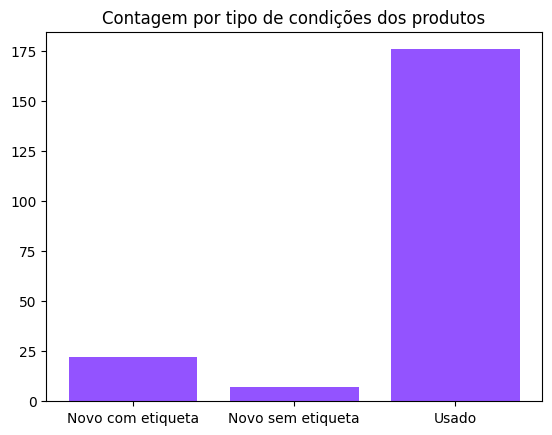

In [12]:
# Criando um gráfico em colunas
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'], color='#9353FF') # color = roxo
plt.title('Contagem por tipo de condições dos produtos')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [13]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [14]:
sql_df ('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [16]:
# Quantidade de produtos vendidos ordem decrescente
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade DESC''' # ordenando produtos (decrescente)

sql_df(query)

,produto,Quantidade
0,Vestido Recortes Cores,795
1,Calca Jeans Costuras,755
2,Saia Pregas Preta,751
3,Calca Alfaiataria Preta,750
4,Saia Midi Cinto,549
...,...,...
196,Blusa Cinza,341
197,Blusa Babados Off-white,337
198,Blusa Malha Azul,325
199,Blusa Listrada Malha,322


In [17]:
# Quantidade de produtos vendidos ordem crescente
query = '''SELECT PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC''' # ordenando produtos (crescente)

df_prod_quant = sql_df(query)
df_prod_quant

,produto,Quantidade
0,Vestido Malha Estampa,318
1,Blusa Listrada Malha,322
2,Blusa Malha Azul,325
3,Blusa Babados Off-white,337
4,Blusa Cinza,341
...,...,...
196,Saia Midi Cinto,549
197,Calca Alfaiataria Preta,750
198,Saia Pregas Preta,751
199,Calca Jeans Costuras,755


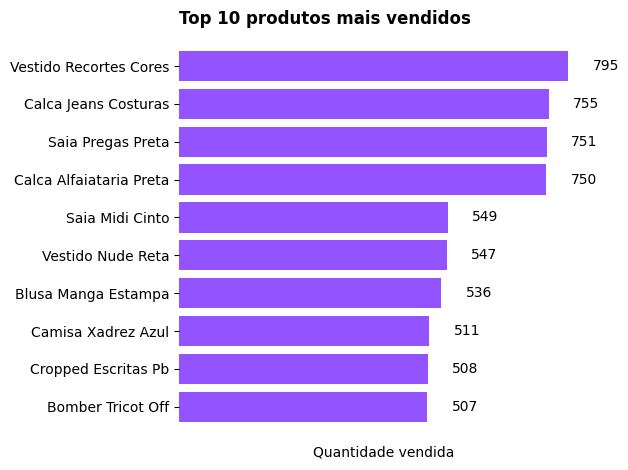

In [84]:
# Gráfico de barras com os top 10 produtos mais vendidos
df_top10 = df_prod_quant.sort_values('Quantidade').reset_index(drop=True)[-10:]

plt.barh(df_top10['produto'], df_top10['Quantidade'], color = '#9353FF')
plt.xlabel('Quantidade vendida')
plt.title('Top 10 produtos mais vendidos', fontweight='bold', loc='left')
plt.xticks([]) # Remove valores do eixo x

# Remover o box (spines)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Mostrar valores nas barras
for i, v in enumerate(df_top10['Quantidade']):
    plt.text(v + 50, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [30]:
# Calculando a receita total obtida com a venda de itens
query = ''' SELECT SUM(VALOR_TOTAL) AS RECEITA
FROM ITENS_PEDIDOS;
'''
df_itens_pedidos = sql_df(query)
df_itens_pedidos

,RECEITA
0,45803930


In [55]:
# Marcas mais pedidas por quantidade (Ordem crescente)
query = ''' SELECT PRODUTOS.MARCA, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY Quantidade ASC'''

df_prod_marcas = sql_df(query)
df_prod_marcas

,marca,Quantidade
0,Track & Field,322
1,Talie Nk,325
2,Bcbgmaxzria,333
3,Express,342
4,All Saints Spitalfields,349
...,...,...
112,Banana Republic,2045
113,Le Lis Blanc,2479
114,Animale,4013
115,Mixed,5748


In [73]:
# 15 marcas mais pedidas por quantidade (Ordem decrescente)
query = ''' SELECT PRODUTOS.MARCA, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.MARCA
ORDER BY Quantidade DESC'''

df_prod_marcas = sql_df(query)
df_prod_marcas.head(15)

,marca,Quantidade
0,Zara,9545
1,Mixed,5748
2,Animale,4013
3,Le Lis Blanc,2479
4,Banana Republic,2045
5,Farm,1779
6,H&m,1576
7,Shoulder,1317
8,Sacada,1285
9,Dress&co,1262


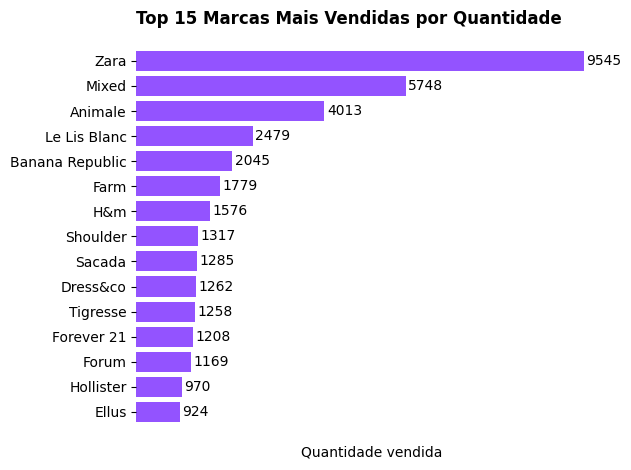

In [85]:
# Criando gráfico de barras
df_top15 = df_prod_marcas.sort_values('Quantidade').reset_index(drop=True)[-15:]

plt.barh(df_top15['marca'], df_top15['Quantidade'], color='#9353FF')
plt.xlabel('Quantidade vendida')
plt.title('Top 15 Marcas Mais Vendidas por Quantidade', fontweight='bold', loc='left')
plt.xticks([]) # Remove os valores do eixo x

# Remover o box (spines)
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Mostrar valores nas barras
for i, v in enumerate(df_top15['Quantidade']):
    plt.text(v + 50, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.